# 04_first_visuals
Developing first steps to an anomaly detection algorithm with visualisations


## Import packages

In [1]:
import sys
import os

import yaml
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

from bokeh.plotting import figure,save, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import ColumnDataSource

from sklearn.preprocessing import MinMaxScaler

from functions.utils import get_folder
from functions.data_loads import get_columns, load_data


pd.set_option('display.float_format', '{:.2f}'.format)

curr_folder = get_folder()
parent_fold = curr_folder.parent
with open(parent_fold / "connections.yml", encoding='utf-8') as file:
    db_config = yaml.safe_load(file)
    
with open(parent_fold / "configurations" / "data_loads.yaml", encoding='utf-8') as file:
    column_conf = yaml.safe_load(file)
    
engine = create_engine(f'postgresql+psycopg2://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["db"]}')

dates = ["01.05.2022","05.05.2022"]

## define functions

In [52]:
def x_coord(x,y):
    """
    This function is transforming the correct coordinates for visualising the data points on a 2D Plot
    """
    lat = float(x)
    lon = float(y)
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale
    return (x, y)

#output_file("visuals.html")

#tile_provider = get_provider(CARTODBPOSITRON)
#visual_df[['lat','lon']] = visual_df[['lat','lon']].apply(lambda x:x_coord(x['lat'],x['lon']),axis = 1, result_type='expand')
#visual_df[['lat','lon']] = [x_coord(x, y) for x, y in visual_df[['lat','lon']].values.tolist()]
#visual = visual_df[['lat', 'lon','mmsi_nunique']][visual_df['msgtime'] == '2022-04-17 11:20:00']

# build your plotty
#p = figure(title="My first interactive plot!", plot_width=800, plot_height=700,
#           x_range=(1500000, 1700000), y_range=(7000000, 12000000),
#           x_axis_type="mercator", y_axis_type="mercator")
#p.add_tile(tile_provider)

# hier nochmal schauen wie die Größe in Abhängigkeit der anzabl an schiffen zu dem zeitpunkt gemessen werden kann
#p.circle(x=visual['lat'], y=visual['lon'], size=visual['mmsi_nunique'], color="red")
#p.circle(x=visual['lat'], y=visual['lon'], size=5, color="red")

#show(p)

def visualize_top_regions(data,columns={'lat':'lat','lon':'lon','size':'mmsi_nunique'}):
    """
    This function creates a plot which visualises the top regions in norway
    """
    tile_provider = get_provider(CARTODBPOSITRON)
    
    MinMax = MinMaxScaler(feature_range=(1,20))
    data[columns['size']] = MinMax.fit_transform(data[columns['size']])
    
    p = figure(title="Most Busy Regions in Norway", plot_width=800, plot_height=700,
           x_range=(1500000, 1700000), y_range=(7000000, 12000000),
           x_axis_type="mercator", y_axis_type="mercator")
    p.add_tile(tile_provider)
    p.circle(x=data[columns['lat']], y=data[columns['lon']], size=data[columns['size']], color="red", fill_alpha=0.5)
    return p
    

In [3]:
columns = get_columns(engine,'tbl_positionagg',column_conf['position_unrel_cols'])
print(columns)
data = load_data(engine,'tbl_positionagg',columns)

['aisclass_count', 'courseoverground_max', 'courseoverground_mean', 'courseoverground_min', 'lat_lon', 'mmsi_nunique', 'msgtime', 'rateofturn_max', 'rateofturn_mean', 'rateofturn_min', 'sog_max', 'sog_mean', 'sog_min', 'trueheading_max', 'trueheading_mean', 'trueheading_min']


In [4]:
data[['lat_lon','aisclass_count']].groupby(['lat_lon']).sum().sort_values(['aisclass_count'],ascending=False)

,aisclass_count
lat_lon,
"60.4,5.3",294794
"59.0,5.7",252853
"69.7,19.0",218837
"59.9,10.7",205164
"63.1,7.7",181595
...,...
"72.6,25.5",1
"72.6,25.6",1
"72.6,26.1",1


In [5]:
data['msgtime'] = pd.to_datetime(data['msgtime'])

## test data set

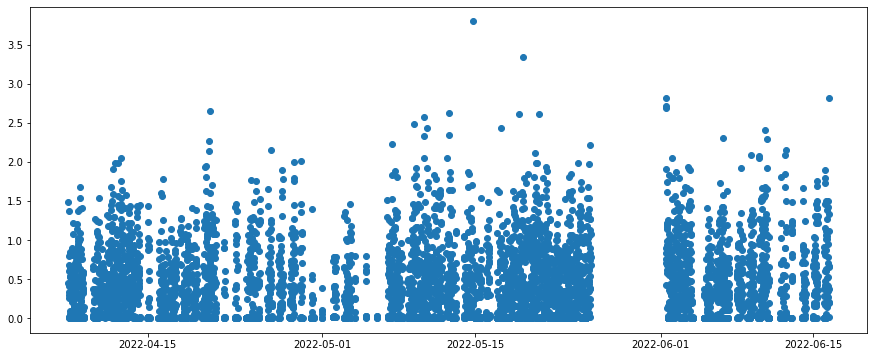

In [6]:
# example plot
filtered_data = data[data['lat_lon'] == '63.1,7.7']

plt.figure(figsize=(15,6))
plt.plot_date(filtered_data['msgtime'],filtered_data['sog_mean'])

In [7]:
meta = data[['lat_lon','aisclass_count']].groupby(['lat_lon']).sum().sort_values(['aisclass_count'],ascending=False).reset_index()

<AxesSubplot:xlabel='aisclass_count'>

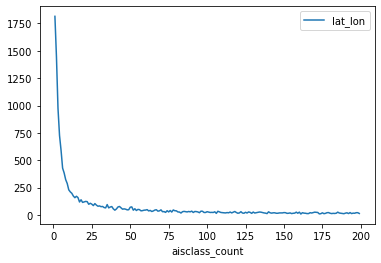

In [8]:
# anzahl der bereiche die nur eine geringe anzahl von messungen haben
meta[meta['aisclass_count'] < 200].groupby(['aisclass_count']).count().plot()

## create interactive visuals on aggregated data

In [9]:
data.head()

,aisclass_count,courseoverground_max,courseoverground_mean,courseoverground_min,lat_lon,mmsi_nunique,msgtime,rateofturn_max,rateofturn_mean,rateofturn_min,sog_max,sog_mean,sog_min,trueheading_max,trueheading_mean,trueheading_min
0,1,0.00,0.00,0.00,"56.6,3.3",1,2022-04-17 11:20:00,0.00,0.00,0.00,0.05,0.05,0.05,0.00,0.00,0.00
1,1,0.00,0.00,0.00,"56.6,3.3",1,2022-04-17 12:30:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1,0.00,0.00,0.00,"56.6,3.3",1,2022-04-17 12:50:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1,0.00,0.00,0.00,"56.6,3.3",1,2022-04-17 13:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1,0.00,0.00,0.00,"56.6,3.3",1,2022-04-17 13:50:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [36]:
data[['lat','lon']] = data['lat_lon'].str.split(',', 1, expand=True)#.apply(lambda x : x.split(',')
visual_df = data[['lat','lon','msgtime','mmsi_nunique']]

In [37]:
visual_df.head()

,lat,lon,msgtime,mmsi_nunique
0,56.6,3.3,2022-04-17 11:20:00,1
1,56.6,3.3,2022-04-17 12:30:00,1
2,56.6,3.3,2022-04-17 12:50:00,1
3,56.6,3.3,2022-04-17 13:00:00,1
4,56.6,3.3,2022-04-17 13:50:00,1


In [49]:
testdf = visual_df[:10]
testdf.head()

,lat,lon,msgtime,mmsi_nunique
0,56.6,3.3,2022-04-17 11:20:00,1
1,56.6,3.3,2022-04-17 12:30:00,1
2,56.6,3.3,2022-04-17 12:50:00,1
3,56.6,3.3,2022-04-17 13:00:00,1
4,56.6,3.3,2022-04-17 13:50:00,1


In [50]:
testdf.loc(,['lat','lon']) = testdf[['lat','lon']].apply(lambda x:x_coord(x['lat'],x['lon']),axis = 1, result_type='expand')
testdf.head()

SyntaxError: invalid syntax (<ipython-input-50-cb34e61a558f>, line 1)

In [51]:
from bokeh.plotting import figure,save, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import ColumnDataSource

def x_coord(x,y):
    
    lat = float(x)
    lon = float(y)
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale
    return (x, y)

output_file("visuals.html")

tile_provider = get_provider(CARTODBPOSITRON)

visual_df[['lat','lon']] = visual_df[['lat','lon']].apply(lambda x:x_coord(x['lat'],x['lon']),axis = 1, result_type='expand')

#visual_df[['lat','lon']] = [x_coord(x, y) for x, y in visual_df[['lat','lon']].values.tolist()]
visual = visual_df[['lat', 'lon','mmsi_nunique']][visual_df['msgtime'] == '2022-04-17 11:20:00']

# build your plotty
p = figure(title="My first interactive plot!", plot_width=800, plot_height=700,
           x_range=(1500000, 1700000), y_range=(7000000, 12000000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

# hier nochmal schauen wie die Größe in Abhängigkeit der anzabl an schiffen zu dem zeitpunkt gemessen werden kann
p.circle(x=visual['lat'], y=visual['lon'], size=visual['mmsi_nunique'], color="red")
#p.circle(x=visual['lat'], y=visual['lon'], size=5, color="red")

show(p)

<ipython-input-51-09ab4a899c35>:12: RuntimeWarning: invalid value encountered in double_scalars
  scale = x/lon
<ipython-input-51-09ab4a899c35>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df[['lat','lon']] = visual_df[['lat','lon']].apply(lambda x:x_coord(x['lat'],x['lon']),axis = 1, result_type='expand')
